### Neural Network Model for Comparison (Max-all)
In comparison to state of the art models, we train a neural network on the normalized data including the raw data. 
Since our dataset comparises image data, a natural thing to do is compare with a CNN model. However, we do not compare with a CNN model because the resolution of the data is small. The data are 10x10 images. We trained CNN models, though but did not get any better results.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from time import perf_counter

class DynamicBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DynamicBinaryClassifier, self).__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x

class BinaryClassifierTrainer:
    def __init__(self, model, criterion, optimizer, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def _to_tensor(self, data):
        if not torch.is_tensor(data):
            data = torch.tensor(data, dtype=torch.float32)
        return data.to(self.device)

    def train(self, input_data, labels, num_epochs=100, batch_size=32):
        input_data, labels = self._to_tensor(input_data), self._to_tensor(labels)

        for epoch in range(num_epochs):
            total_loss = 0.0

            # Forward pass and calculate loss
            for i in range(0, len(input_data), batch_size):
                batch_input = input_data[i:i + batch_size]
                batch_labels = labels[i:i + batch_size]

                outputs = self.model(batch_input)
                loss = self.criterion(outputs, batch_labels)

                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()

            average_loss = total_loss / (len(input_data) / batch_size)

            # Print the average loss every 100 epochs
            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {average_loss:.8f}')

    def evaluate(self, input_data, labels):
        input_data, labels = self._to_tensor(input_data), self._to_tensor(labels)

        with torch.no_grad():
            outputs = self.model(input_data)
            predictions = (outputs > 0.5).float()

        accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        return accuracy
   

In [2]:
 
from glob import glob

# Example usage:
input_size = 100
hidden_sizes = [70,64, 32]
output_size = 1

model = DynamicBinaryClassifier(input_size, hidden_sizes, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

trainer = BinaryClassifierTrainer(model, criterion, optimizer)

start = perf_counter()
# read data
batch_size = 128
files = glob('../../data/data-norm/max-pixel-all/*.csv')
file_names = [f.split('/')[-1] for f in files]
results = {name:[] for name in file_names}
for name in results:
    for _ in range(3):
        print(name)
        dat = pd.read_csv(f'../../data/data-norm/max-pixel-all/{name}')
        data = dat.iloc[:, 1:].values
        labels = dat.iloc[:, 0].values.reshape(-1, 1)
        # Split the data into training and test sets
        input_train, input_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, random_state=42)
        # Training
        trainer.train(input_train, labels_train, num_epochs=200, batch_size=batch_size)
        # Evaluation
        test_accuracy = trainer.evaluate(input_test, labels_test)
        print(f'Test Accuracy: {test_accuracy:.4f}')
        results[name].append(test_accuracy)
data_accuracies = pd.DataFrame(results)
data_accuracies.to_csv('../../data/data-norm/accuracies-nnet-max-all.csv', index=False)

end = perf_counter()
print(f'Total time taken: {(end-start)/60:.6f} minutes')
# dat = pd.read_csv('../../data/data-norm/max-only/raw_image_data.csv')
# data = dat.iloc[:, 1:].values
# labels = dat.iloc[:, 0].values.reshape(-1, 1)

# # Split the data into training and test sets
# input_train, input_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# # Training
# trainer.train(input_train, labels_train, num_epochs=1000, batch_size=32)

# # Evaluation
# test_accuracy = trainer.evaluate(input_test, labels_test)
# print(f'Test Accuracy: {test_accuracy:.4f}')


norm_1_data.csv
Epoch [100/200], Average Loss: 0.50620754
Epoch [200/200], Average Loss: 0.47587905
Test Accuracy: 0.7399
norm_1_data.csv
Epoch [100/200], Average Loss: 0.45274650
Epoch [200/200], Average Loss: 0.43312552
Test Accuracy: 0.7472
norm_1_data.csv
Epoch [100/200], Average Loss: 0.41499026
Epoch [200/200], Average Loss: 0.39766189
Test Accuracy: 0.7496
nthroot_0.4828.csv
Epoch [100/200], Average Loss: 0.53570529


In [ ]:
import pandas as pd
data_accuracies = pd.read_csv('../../data/data-norm/accuracies-nnet-max-all.csv')

In [ ]:
# return column with max value
data_accuracies.idxmax(axis=1)


0    nthroot_0.4483_data.csv
1         nthroot_0.5862.csv
2    nthroot_0.4483_data.csv
dtype: object

In [ ]:
import numpy as np
np.max(data_accuracies, axis=1)

0    0.774537
1    0.777105
2    0.774904
dtype: float64

In [ ]:
idcs = np.argmax(data_accuracies.values, axis=1)
idcs

array([7, 6, 7])

In [ ]:
data_accuracies.iloc[:, idcs]

,nthroot_0.4483_data.csv,nthroot_0.5862.csv,nthroot_0.4483_data.csv
0,0.774537,0.774170,0.774537
1,0.775087,0.777105,0.775087
2,0.774904,0.770501,0.774904


Of all normalizations as well as the raw data, the $r^{th}$ with max-all over each image performs the best at an average of $77\%$ accuracy on $20\%$ test data for neural nets models. So judging from these runs, we conlcude that for neural net models, dividing each pixel with the absolute max over the entire dataset is more benefitial than dividing by max over each image.

In [ ]:
data_accuracies.mean(axis=0).nlargest(10)

nthroot_0.4483_data.csv    0.774843
nthroot_0.5862.csv         0.773925
nthroot_0.5862_data.csv    0.766587
nthroot_0.7931.csv         0.763346
nthroot_0.5172.csv         0.752278
nthroot_1.0.csv            0.750199
norm_1_data.csv            0.747875
nthroot_0.4828.csv         0.737541
norm_41_data.csv           0.631383
norm_31_data.csv           0.618908
dtype: float64

### Vary Test Size
We check DNN performance when the test size changes. Use the top performing normalization `nthroot_0.5862.csv` file as well the optimized DNN hyperparameters

In [3]:

# Example usage:
input_size = 100
hidden_sizes = [70,64, 32]
output_size = 1
# test sizes 
train_sizes = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5,0.4,0.3,0.2,0.1]
accuracy = {i:[] for i in train_sizes}

dat = pd.read_csv('../../data/data-norm/max-pixel-all/nthroot_0.5862.csv')
data = dat.iloc[:, 1:].values
labels = dat.iloc[:, 0].values.reshape(-1, 1)
for i, num in enumerate(train_sizes):
    # run couple of times
    for _ in range(3):
        model = DynamicBinaryClassifier(input_size, hidden_sizes, output_size)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        trainer = BinaryClassifierTrainer(model, criterion, optimizer)
        batch_size = 128

        # Split the data into training and test sets
        input_train, input_test, labels_train, labels_test = train_test_split(data, labels, train_size=0.2, random_state=42)
        # get num percentage of training data
        # train_size won't accept 1.0, resort to train size
        temp_num=None
        if num == 1.0:
            temp_num = num
            num = int(len(input_train)) - 1   # -1 to avoid empty tensor
        input_train, _, labels_train, _ = train_test_split(input_train, labels_train, train_size=num, random_state=42)
        if temp_num:
            num = temp_num

        # Training
        trainer.train(input_train, labels_train, num_epochs=5000, batch_size=batch_size)

        # Evaluation
        test_accuracy = trainer.evaluate(input_test, labels_test)
        print(f'Test Accuracy: {test_accuracy:.4f}')
        accuracy[num].append(test_accuracy*100)


Epoch [100/5000], Average Loss: 0.63515377
Epoch [200/5000], Average Loss: 0.59384577
Epoch [300/5000], Average Loss: 0.57089741
Epoch [400/5000], Average Loss: 0.56067075
Epoch [500/5000], Average Loss: 0.55313288
Epoch [600/5000], Average Loss: 0.54798395
Epoch [700/5000], Average Loss: 0.54378209
Epoch [800/5000], Average Loss: 0.53918287
Epoch [900/5000], Average Loss: 0.53571763
Epoch [1000/5000], Average Loss: 0.53302630
Epoch [1100/5000], Average Loss: 0.52950280
Epoch [1200/5000], Average Loss: 0.52622631
Epoch [1300/5000], Average Loss: 0.52359590
Epoch [1400/5000], Average Loss: 0.52003026
Epoch [1500/5000], Average Loss: 0.51746077
Epoch [1600/5000], Average Loss: 0.51384635
Epoch [1700/5000], Average Loss: 0.51004781
Epoch [1800/5000], Average Loss: 0.50680383
Epoch [1900/5000], Average Loss: 0.50335095
Epoch [2000/5000], Average Loss: 0.49937122
Epoch [2100/5000], Average Loss: 0.49601718
Epoch [2200/5000], Average Loss: 0.49230493
Epoch [2300/5000], Average Loss: 0.489211

In [4]:
# pickle save accuracy dict
import pickle
with open('../vary-test-size/DNN-accuracy-new.pickle', 'wb') as handle:
    pickle.dump(accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# read trained data 
with open('../vary-test-size/DNN-accuracy-new.pickle', 'rb') as handle:
    accuracies = pickle.load(handle)
accuracies = pd.DataFrame(accuracies)
accuracies

,1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1
0,72.172278,72.516283,72.745620,70.745803,70.869645,69.819283,70.470599,70.461426,68.622145,67.149803
1,71.296211,71.970461,71.915421,70.901752,69.943124,71.511788,70.218329,70.686176,68.874415,67.608476
2,71.773232,70.433905,71.016421,69.768829,70.672415,70.984313,70.626548,70.392625,69.209247,67.723145


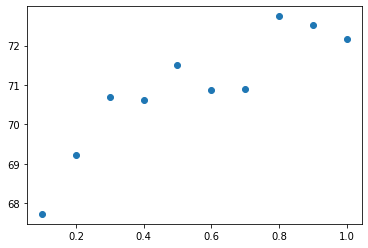

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.scatter(train_sizes, np.max(accuracies, axis=0).values)
plt.show()